## Modelling and selection of best model

__Table of Contents:__
<br>[1. Train and Test Data Analysis](#1.-Train-and-Test-Data-Analysis)
<br>[2. Feature Engineering](#2.-Feature-Engineering)
<br>[3. Modelling](#3.-Modelling)
<br>&emsp;&emsp;[3A. Analysis & Evaluation of Best Model](#3A.\-Analysis-&-Evaluation-of-Best-Model)
<br>[4. Submission to Kaggle](#4.-Submission-to-Kaggle)
<br>[5. Conclusion](#5.-Conclusion)

In [1]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt 
from sklearn.svm import SVC
from sklearn.metrics import roc_auc_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from imblearn.over_sampling import SMOTE

pd.set_option('display.max_columns', 999)

In [2]:
# Importing of data
train_clean = pd.read_csv('../assets/df_tr_full.csv')
test_clean = pd.read_csv('../assets/df_tst_full.csv')
sample = pd.read_csv('sampleSubmission.csv')

## 1. Train and Test Data Analysis

In [3]:
# Understanding the size of both datasets
print(f'Train data dimensions: {train_clean.shape}')
print(f'Test data dimensions: {test_clean.shape}')

Train data dimensions: (10506, 35)
Test data dimensions: (116293, 34)


In [4]:
# Checking for presence of null values in both datasets
isnull = pd.DataFrame([train_clean.isnull().sum(),test_clean.isnull().sum()],index=['Train_null','Test_null'])
isnull

,Date,month,year,Block,Latitude,Longitude,Street,Trap,Tmax,Tmin,Tavg,DewPoint,dew_point_depression,WetBulb,wet_bulb_depression,Heat,Cool,relative_humidity,Sunrise,Sunset,daytime,Species,WnvPresent,PrecipTotal,StnPressure,ResultSpeed,ResultDir,VCTS,RA,HZ,BR,FG,DZ,TSRA,TS
Train_null,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Test_null,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


No observed null values in either dataset. WnvPresent column is absent in test dataset, since it is the predicted variable.

In [5]:
# Quick statistics overview of train data
train_clean.describe()

,month,year,Block,Latitude,Longitude,Tmax,Tmin,Tavg,DewPoint,dew_point_depression,WetBulb,wet_bulb_depression,Heat,Cool,relative_humidity,WnvPresent,PrecipTotal,StnPressure,ResultSpeed,ResultDir,VCTS,RA,HZ,BR,FG,DZ,TSRA,TS
count,10506.000000,10506.000000,10506.000000,10506.000000,10506.000000,10506.000000,10506.000000,10506.000000,10506.000000,10506.000000,10506.000000,10506.000000,10506.000000,10506.000000,10506.000000,10506.000000,10506.000000,10506.000000,10506.000000,10506.000000,10506.000000,10506.000000,10506.000000,10506.000000,10506.000000,10506.000000,10506.000000,10506.000000
mean,7.692557,2009.576242,35.687797,41.841139,-87.699908,81.847992,62.716067,72.530459,59.759566,12.770893,64.590996,7.939463,0.958214,8.488673,64.832857,0.052446,0.181160,29.254920,5.976623,17.520084,0.018942,0.304397,0.171331,0.278317,0.010661,0.016181,0.132115,0.052256
std,1.067675,2.354645,24.339468,0.112742,0.096514,8.278380,7.677123,7.523979,7.785968,3.963800,6.791808,2.559181,2.863326,5.669404,8.956048,0.222936,0.472302,0.115612,2.838635,9.509825,0.136325,0.460174,0.376816,0.448192,0.102703,0.126178,0.338632,0.222553
min,5.000000,2007.000000,10.000000,41.644612,-87.930995,57.000000,41.000000,50.000000,39.000000,4.000000,46.000000,1.000000,0.000000,0.000000,42.000000,0.000000,0.000000,28.890000,0.100000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,7.000000,2007.000000,12.000000,41.732984,-87.760070,78.000000,58.000000,69.000000,54.000000,9.000000,61.000000,6.000000,0.000000,4.000000,57.000000,0.000000,0.000000,29.180000,3.800000,8.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,8.000000,2009.000000,33.000000,41.846283,-87.694991,83.000000,64.000000,74.000000,60.000000,13.000000,65.000000,8.000000,0.000000,9.000000,64.000000,0.000000,0.000000,29.260000,5.500000,19.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,8.000000,2011.000000,52.000000,41.954690,-87.627796,88.000000,69.000000,78.000000,67.000000,16.000000,70.000000,10.000000,0.000000,13.000000,74.000000,0.000000,0.160000,29.340000,7.600000,25.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000
max,10.000000,2013.000000,98.000000,42.017430,-87.531635,96.000000,76.000000,84.000000,73.000000,24.000000,76.000000,18.000000,15.000000,19.000000,87.000000,1.000000,3.970000,29.590000,14.600000,36.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [6]:
# Observation for first 5 rows in train dataset
train_clean.head()

,Date,month,year,Block,Latitude,Longitude,Street,Trap,Tmax,Tmin,Tavg,DewPoint,dew_point_depression,WetBulb,wet_bulb_depression,Heat,Cool,relative_humidity,Sunrise,Sunset,daytime,Species,WnvPresent,PrecipTotal,StnPressure,ResultSpeed,ResultDir,VCTS,RA,HZ,BR,FG,DZ,TSRA,TS
0,2007-05-29,5,2007,41,41.954690,-87.800991,N OAK PARK AVE,T002,88,60,74.0,58,16.0,65.0,9.0,0.0,9.0,57,0 days 04:21:00.000000000,0 days 19:17:00.000000000,0 days 14:56:00.000000000,CULEX PIPIENS/RESTUANS,0.0,0.0,29.39,5.8,18,0,0,1,1,0,0,0,0
1,2007-05-29,5,2007,41,41.954690,-87.800991,N OAK PARK AVE,T002,88,60,74.0,58,16.0,65.0,9.0,0.0,9.0,57,0 days 04:21:00.000000000,0 days 19:17:00.000000000,0 days 14:56:00.000000000,CULEX RESTUANS,0.0,0.0,29.39,5.8,18,0,0,1,1,0,0,0,0
2,2007-05-29,5,2007,62,41.994991,-87.769279,N MANDELL AVE,T007,88,60,74.0,58,16.0,65.0,9.0,0.0,9.0,57,0 days 04:21:00.000000000,0 days 19:17:00.000000000,0 days 14:56:00.000000000,CULEX RESTUANS,0.0,0.0,29.39,5.8,18,0,0,1,1,0,0,0,0
3,2007-05-29,5,2007,79,41.974089,-87.824812,W FOSTER AVE,T015,88,60,74.0,58,16.0,65.0,9.0,0.0,9.0,57,0 days 04:21:00.000000000,0 days 19:17:00.000000000,0 days 14:56:00.000000000,CULEX PIPIENS/RESTUANS,0.0,0.0,29.39,5.8,18,0,0,1,1,0,0,0,0
4,2007-05-29,5,2007,79,41.974089,-87.824812,W FOSTER AVE,T015,88,60,74.0,58,16.0,65.0,9.0,0.0,9.0,57,0 days 04:21:00.000000000,0 days 19:17:00.000000000,0 days 14:56:00.000000000,CULEX RESTUANS,0.0,0.0,29.39,5.8,18,0,0,1,1,0,0,0,0


In [7]:
# Quick statistics overview of test data
test_clean.describe()

,month,year,Block,Latitude,Longitude,Tmax,Tmin,Tavg,DewPoint,dew_point_depression,WetBulb,wet_bulb_depression,Heat,Cool,relative_humidity,PrecipTotal,StnPressure,ResultSpeed,ResultDir,VCTS,RA,HZ,BR,FG,DZ,TSRA,TS
count,116293.000000,116293.000000,116293.000000,116293.000000,116293.000000,116293.000000,116293.000000,116293.000000,116293.000000,116293.000000,116293.00000,116293.000000,116293.000000,116293.000000,116293.000000,116293.000000,116293.000000,116293.000000,116293.000000,116293.0,116293.000000,116293.000000,116293.000000,116293.0,116293.000000,116293.000000,116293.000000
mean,7.620244,2010.702759,41.131100,41.849389,-87.693658,81.082146,61.351371,71.495774,57.282777,14.212996,62.97539,8.520384,0.629479,7.125253,61.648818,0.164713,29.272241,6.414371,18.151626,0.0,0.315565,0.031567,0.242396,0.0,0.010534,0.168531,0.084554
std,1.065842,2.128750,24.864726,0.106593,0.080699,7.585843,6.253323,6.423224,7.159588,4.538676,5.77305,2.611236,1.862324,5.368341,9.928005,0.444764,0.119641,2.839094,10.334646,0.0,0.464742,0.174845,0.428535,0.0,0.102092,0.374339,0.278218
min,6.000000,2008.000000,10.000000,41.644612,-87.930995,56.000000,48.000000,53.000000,39.000000,4.000000,47.00000,2.000000,0.000000,0.000000,37.000000,0.000000,29.000000,0.600000,1.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000
25%,7.000000,2008.000000,18.000000,41.753411,-87.750938,76.000000,56.000000,67.000000,52.000000,11.000000,59.00000,7.000000,0.000000,2.000000,54.000000,0.000000,29.180000,4.500000,7.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000
50%,8.000000,2010.000000,39.000000,41.862292,-87.694991,82.000000,62.000000,72.000000,57.000000,14.000000,63.00000,9.000000,0.000000,7.000000,61.000000,0.000000,29.270000,6.200000,19.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000
75%,8.000000,2012.000000,61.000000,41.951866,-87.648860,87.000000,66.000000,77.000000,63.000000,18.000000,68.00000,10.000000,0.000000,12.000000,69.000000,0.070000,29.360000,8.100000,27.000000,0.0,1.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000
max,10.000000,2014.000000,98.000000,42.017430,-87.531635,95.000000,73.000000,83.000000,71.000000,28.000000,74.00000,15.000000,12.000000,18.000000,87.000000,2.790000,29.590000,16.600000,36.000000,0.0,1.000000,1.000000,1.000000,0.0,1.000000,1.000000,1.000000


In [8]:
# Observation for first 5 rows in test dataset
test_clean.head()

,Date,month,year,Block,Latitude,Longitude,Street,Trap,Tmax,Tmin,Tavg,DewPoint,dew_point_depression,WetBulb,wet_bulb_depression,Heat,Cool,relative_humidity,Sunrise,Sunset,daytime,Species,PrecipTotal,StnPressure,ResultSpeed,ResultDir,VCTS,RA,HZ,BR,FG,DZ,TSRA,TS
0,2008-06-11,6,2008,41,41.95469,-87.800991,N OAK PARK AVE,T002,86,61,74.0,56,18.0,64.0,10.0,0.0,9.0,53,0 days 04:16:00.000000000,0 days 19:26:00.000000000,0 days 15:10:00.000000000,CULEX PIPIENS/RESTUANS,0.0,29.28,8.9,18,0,0,0,0,0,0,0,0
1,2008-06-11,6,2008,41,41.95469,-87.800991,N OAK PARK AVE,T002,86,61,74.0,56,18.0,64.0,10.0,0.0,9.0,53,0 days 04:16:00.000000000,0 days 19:26:00.000000000,0 days 15:10:00.000000000,CULEX RESTUANS,0.0,29.28,8.9,18,0,0,0,0,0,0,0,0
2,2008-06-11,6,2008,41,41.95469,-87.800991,N OAK PARK AVE,T002,86,61,74.0,56,18.0,64.0,10.0,0.0,9.0,53,0 days 04:16:00.000000000,0 days 19:26:00.000000000,0 days 15:10:00.000000000,CULEX PIPIENS,0.0,29.28,8.9,18,0,0,0,0,0,0,0,0
3,2008-06-11,6,2008,41,41.95469,-87.800991,N OAK PARK AVE,T002,86,61,74.0,56,18.0,64.0,10.0,0.0,9.0,53,0 days 04:16:00.000000000,0 days 19:26:00.000000000,0 days 15:10:00.000000000,CULEX SALINARIUS,0.0,29.28,8.9,18,0,0,0,0,0,0,0,0
4,2008-06-11,6,2008,41,41.95469,-87.800991,N OAK PARK AVE,T002,86,61,74.0,56,18.0,64.0,10.0,0.0,9.0,53,0 days 04:16:00.000000000,0 days 19:26:00.000000000,0 days 15:10:00.000000000,CULEX TERRITANS,0.0,29.28,8.9,18,0,0,0,0,0,0,0,0


## 2. Feature Engineering

Columns were further pre-processed for modelling:
- A long_lat and blk_str column was created, with its individual columns dropped from both dataests
- The values in sunrise, sunset and daytime columns were reduced to display the time in 0000Hrs format
- Top 40 correlated columns were selected for modelling
- Columns were modified using dummy variables, polynomial with degree 2, scaled with Standard Scalar
- Train-test split was carried out on the train dataset for model training and selection. Oversampling was carried out on the train in train dataset, due to imbalanced data.

In [9]:
# Applying lowercase on column names in both dataset
train_clean.columns = train_clean.columns.map(lambda x: x.lower())
test_clean.columns = test_clean.columns.map(lambda x: x.lower())

In [10]:
# Create long-lat column based on multiplication of latitude and longitude, and removing individual columns
train_clean['long_lat'] = train_clean['latitude']*train_clean['longitude']
train_clean.drop(['latitude','longitude'],axis=1,inplace=True)
test_clean['long_lat'] = test_clean['latitude']*test_clean['longitude']
test_clean.drop(['latitude','longitude'],axis=1,inplace=True)

In [11]:
# Create a blk_str column based on combination of block and street, and removing individual columns
train_clean['blk_str'] = train_clean['block'].astype(str)+train_clean['street']
train_clean.drop(['block','street'],axis=1,inplace=True)
test_clean['blk_str'] = test_clean['block'].astype(str)+test_clean['street']
test_clean.drop(['block','street'],axis=1,inplace=True)

In [12]:
# Converting time columns into palatable integer columns that can be utilized by the model
for i in ['sunrise','sunset','daytime']:
    train_clean[i] = train_clean[i].str.slice(7, -13, 1)
    train_clean[i].replace(':','',regex=True,inplace=True)
    train_clean[i] = train_clean[i].astype('int64')
    test_clean[i] = test_clean[i].str.slice(7, -13, 1)
    test_clean[i].replace(':','',regex=True,inplace=True)
    test_clean[i] = test_clean[i].astype('int64')

In [13]:
# Dropping of date and blk_str columns
train_clean.drop(['date','blk_str'],axis=1,inplace=True)
test_clean.drop(['date','blk_str'],axis=1,inplace=True)

In [14]:
# Create dummy variables based on a combined dataset.
train_objs_num = len(train_clean)
dataset = pd.concat(objs=[train_clean.drop('wnvpresent',axis=1), test_clean], axis=0)
dataset = pd.get_dummies(dataset)

# Extracting train dataset with dummy variables
train_dum = dataset[:train_objs_num]
# Extracting test dataset with dummy variables
test_dum = dataset[train_objs_num:]

In [15]:
# Adding of wnvpresent column into the train dataset
train_dum['wnvpresent'] = train_clean['wnvpresent']

/Users/KeithTan/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [16]:
# Finding top 40 correlated columns
corrmat = train_dum.corr()
columns = abs(corrmat['wnvpresent']).sort_values(ascending=False).head(41)
columns

wnvpresent                  1.000000
sunrise                     0.105227
month                       0.100143
species_CULEX PIPIENS       0.096206
species_CULEX RESTUANS      0.092094
dewpoint                    0.090460
daytime                     0.086210
wetbulb                     0.084959
tmin                        0.072719
sunset                      0.070076
tavg                        0.066043
cool                        0.058953
ts                          0.057956
heat                        0.056813
relative_humidity           0.056740
tsra                        0.055740
dew_point_depression        0.052328
resultspeed                 0.051177
year                        0.050865
tmax                        0.050536
trap_T900                   0.044220
long_lat                    0.040481
species_CULEX TERRITANS     0.034566
trap_T143                   0.034433
ra                          0.032734
wet_bulb_depression         0.031308
trap_T003                   0.030296
v

In [17]:
# Train test split within the train dataset, using the top 40 columns
X_train, X_test, y_train, y_test = train_test_split(train_dum[[x for x in columns.index if x != 'wnvpresent']],
                                                    train_dum['wnvpresent'],
                                                    stratify = train_dum['wnvpresent'].values,
                                                    test_size = 0.25,
                                                    random_state=42)

In [18]:
X_train_col = X_train.columns

In [19]:
# PolyNomial with default degree=2
poly = PolynomialFeatures(include_bias=False)

X_train = poly.fit_transform(X_train)
X_test = poly.transform(X_test)

test = poly.fit_transform(test_dum[[x for x in columns.index if x != 'wnvpresent']])

In [20]:
# Creation of new variable for feature observation later
X_train_poly_col = poly.get_feature_names(X_train_col)

In [21]:
# Initiate, fit and transform standard scaler
ss = StandardScaler()
X_train = ss.fit_transform(X_train)
X_test = ss.transform(X_test)
test = ss.transform(test)

In [22]:
# Cater for imbalanced data by oversampling the train data in train dataset
smt = SMOTE()
X_train, y_train = smt.fit_sample(X_train, y_train)

## 3. Modelling

From the top 40 correlated features selected from above, a series of classification models was passed into GridSearch, with varying parameters, to find the best model for the dataset. Models include Logistic Regression, K-Nearest Neighbors, Decision Tree, Random Forest, Extra Trees Classifier, Gradient Boosting and Ada Boost.

In [23]:
# Initialize dictionaries for models
model_dict = {
   'lr': LogisticRegression(),
   'knn': KNeighborsClassifier(),
   'dt': DecisionTreeClassifier(),
   'svm': SVC(),
   'rf' : RandomForestClassifier(n_estimators=100),
   'et' : ExtraTreesClassifier(n_estimators=100),
   'gbc' : GradientBoostingClassifier(n_estimators=100),
   'abc' : AdaBoostClassifier(n_estimators=100)
}

model_full = {
   'lr': 'Logistic Regression',
   'knn': 'KNearestNeighbor',
   'dt': 'DecisionTreeClassifier',
   'svm' : 'Support Vector Classifier',
   'rf' : 'Random Tree Classifier',
   'et' : 'Extra Tree Classifier',
   'gbc' : 'GradientBoostingClassifier',
   'abc' : 'AdaBoostClassifier'
}

# Initialize functions for pipeline
def prepare_pipeline(model):
    pipe_list = (model,model_dict[model])
    return Pipeline([pipe_list])

# Initialize functions for parameters
def prepare_params(model):
    if model == 'lr':
        return {'lr__solver' : ['newton-cg', 'lbfgs', 'liblinear']
                }
    elif model == 'knn':
        return {'knn__n_neighbors' : [5,6]
                }
    elif model == 'dt':
        return {'dt__max_depth' : [3, 5],
                'dt__min_samples_split' : [5, 10],
                'dt__min_samples_leaf' : [2, 3]
                }  
    elif model == 'svm':
        return {'svm__gamma' : np.logspace(-5,2,2),
                'svm__C' : np.logspace(-3,2,2),
                'svm__kernel' : ['rbf', 'sigmoid']
                }
    elif model == 'rf':
        return {
                'rf__n_estimators': [100, 150, 200],
                'rf__max_depth': [3, 4, 5],
                'rf__min_samples_leaf' : [1,2,3]
                }
    elif model == 'et':
        return {
                'et__n_estimators': [100, 150, 200],
                'et__max_depth': [3, 4, 5],
                'et__min_samples_leaf' : [1,2,3]
                }
    elif model == 'gbc':
        return {
                'gbc__learning_rate': [0.1,0.2,0.5],
                'gbc__max_depth': [3, 4, 5],
                }
    elif model == 'abc':
        return {
                'abc__learning_rate': [0.2,0.5,0.73],
                }

# Initialize functions for grid search, calling on above functions, and printing model metrics
def grid_search(model,X_train=X_train,y_train=y_train,X_test=X_test,y_test=y_test,n_jobs=-1):
    pipe_params = prepare_params(model)
    pipe = prepare_pipeline(model)
    gs = GridSearchCV(pipe,param_grid=pipe_params,cv=3)
    gs.fit(X_train,y_train)
    print(f'Results from {model_full[model]}:')
    print(f'Train Score: {round(gs.best_score_,4)}')
    print(f'Test Score: {round(gs.score(X_test,y_test),4)}')
    print(f'Using the following parameters: {gs.best_params_}')
    print('\n')
    tn, fp, fn, tp = confusion_matrix(y_test, gs.best_estimator_.predict(X_test)).ravel()
    print('From Confusion Matrix:')
    print("True Negatives: %s" % tn)
    print("False Positives: %s" % fp)
    print("False Negatives: %s" % fn)
    print("True Positives: %s" % tp)
    print('\n')
    report = classification_report(y_test, gs.best_estimator_.predict(X_test), target_names=['Predict 0', 'Predict 1'], output_dict=True)
    class_table = pd.DataFrame(report).transpose().drop(['macro avg','weighted avg'],axis=0)
    return class_table


In [24]:
grid_search('knn')

Results from KNearestNeighbor:
Train Score: 0.8432
Test Score: 0.8515
Using the following parameters: {'knn__n_neighbors': 5}


From Confusion Matrix:
True Negatives: 2177
False Positives: 312
False Negatives: 78
True Positives: 60




,precision,recall,f1-score,support
Predict 0,0.965410,0.874648,0.917791,2489.000000
Predict 1,0.161290,0.434783,0.235294,138.000000
accuracy,0.851542,0.851542,0.851542,0.851542


In [25]:
grid_search('lr')

/Users/KeithTan/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/Users/KeithTan/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/Users/KeithTan/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


Results from Logistic Regression:
Train Score: 0.8223
Test Score: 0.7655
Using the following parameters: {'lr__solver': 'newton-cg'}


From Confusion Matrix:
True Negatives: 1922
False Positives: 567
False Negatives: 49
True Positives: 89




,precision,recall,f1-score,support
Predict 0,0.975140,0.772198,0.861883,2489.000000
Predict 1,0.135671,0.644928,0.224181,138.000000
accuracy,0.765512,0.765512,0.765512,0.765512


In [26]:
grid_search('dt')

Results from DecisionTreeClassifier:
Train Score: 0.803
Test Score: 0.7061
Using the following parameters: {'dt__max_depth': 5, 'dt__min_samples_leaf': 3, 'dt__min_samples_split': 5}


From Confusion Matrix:
True Negatives: 1757
False Positives: 732
False Negatives: 40
True Positives: 98




,precision,recall,f1-score,support
Predict 0,0.977741,0.705906,0.819879,2489.000000
Predict 1,0.118072,0.710145,0.202479,138.000000
accuracy,0.706129,0.706129,0.706129,0.706129


In [27]:
grid_search('rf')

Results from Random Tree Classifier:
Train Score: 0.8255
Test Score: 0.7278
Using the following parameters: {'rf__max_depth': 5, 'rf__min_samples_leaf': 1, 'rf__n_estimators': 100}


From Confusion Matrix:
True Negatives: 1812
False Positives: 677
False Negatives: 38
True Positives: 100




,precision,recall,f1-score,support
Predict 0,0.979459,0.728003,0.835215,2489.000000
Predict 1,0.128700,0.724638,0.218579,138.000000
accuracy,0.727826,0.727826,0.727826,0.727826


In [28]:
grid_search('et')

Results from Extra Tree Classifier:
Train Score: 0.7948
Test Score: 0.7244
Using the following parameters: {'et__max_depth': 5, 'et__min_samples_leaf': 2, 'et__n_estimators': 100}


From Confusion Matrix:
True Negatives: 1798
False Positives: 691
False Negatives: 33
True Positives: 105




,precision,recall,f1-score,support
Predict 0,0.981977,0.722378,0.832407,2489.0000
Predict 1,0.131910,0.760870,0.224839,138.0000
accuracy,0.724400,0.724400,0.724400,0.7244


In [29]:
grid_search('gbc')

Results from GradientBoostingClassifier:
Train Score: 0.9115
Test Score: 0.8786
Using the following parameters: {'gbc__learning_rate': 0.5, 'gbc__max_depth': 5}


From Confusion Matrix:
True Negatives: 2258
False Positives: 231
False Negatives: 88
True Positives: 50




,precision,recall,f1-score,support
Predict 0,0.962489,0.907192,0.934023,2489.000000
Predict 1,0.177936,0.362319,0.238663,138.000000
accuracy,0.878569,0.878569,0.878569,0.878569


In [30]:
grid_search('abc')

Results from AdaBoostClassifier:
Train Score: 0.8589
Test Score: 0.8017
Using the following parameters: {'abc__learning_rate': 0.73}


From Confusion Matrix:
True Negatives: 2020
False Positives: 469
False Negatives: 52
True Positives: 86




,precision,recall,f1-score,support
Predict 0,0.974903,0.811571,0.885771,2489.000000
Predict 1,0.154955,0.623188,0.248196,138.000000
accuracy,0.801675,0.801675,0.801675,0.801675


### 3A. Analysis & Evaluation of Best Model

Given that the train dataset had an imbalanced data (low % of cases where West Nile Virus was present), accuracy should be disregarded as a model evaluation metric since it will always display good results - we should look at other metrics i.e. precision, recall, f1-score. We used f1-score as the deciding metric, in order to achieve a balance between low false positives (to lower cost of spraying) and false negatives (to prevent missing out on spraying where the virus was actually present).

AdaBoost, with a parameter of learning rate of 0.73, was selected as the best performing model, based on the high f-1 score.

In [31]:
# Reinstating of best model with optimal parameters
abc = AdaBoostClassifier(n_estimators=100, learning_rate = 0.73)
abc.fit(X_train,y_train)

pred = abc.predict(test)
pred_proba_t = [i[1] for i in abc.predict_proba(test)]

In [32]:
# Visualization of top 10 correlated features
abc_feature_impt = abc.feature_importances_
abc_features = []
for i in np.argsort(abc_feature_impt)[::-1]:
    abc_features.append(X_train_poly_col[i])
abc_features[:10]

['month wet_bulb_depression',
 'month year',
 'month long_lat',
 'sunrise daytime',
 'species_CULEX RESTUANS preciptotal',
 'month tmin',
 'month relative_humidity',
 'species_CULEX PIPIENS cool',
 'species_CULEX PIPIENS sunset',
 'daytime relative_humidity']

In [33]:
# Sanity check on the predicted values
np.unique(pred)

array([0., 1.])

In [34]:
# Table on actual values versus predicted probabilities
pred_proba = [i[1] for i in abc.predict_proba(X_test)]
pred_df = pd.DataFrame({'true_values': y_test,
                        'pred_probs':pred_proba})
pred_df

,true_values,pred_probs
1554,0.0,0.493840
3181,0.0,0.401579
7921,0.0,0.410512
3536,0.0,0.485124
3034,0.0,0.494724
...,...,...
301,0.0,0.374370
249,0.0,0.382758
1405,0.0,0.496873
9669,0.0,0.504543


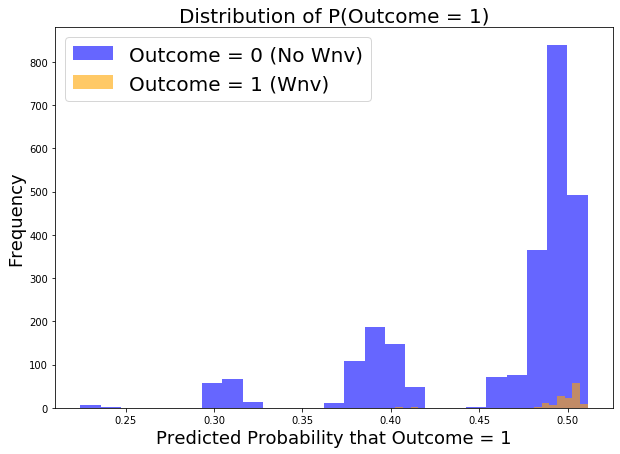

In [35]:
# Create figure for distribution graph
plt.figure(figsize = (10,7))

# Creatinfg two histograms of observations, with blue (left) from r/raok and yellow (right) from r/nosleep
plt.hist(pred_df[pred_df['true_values'] == 0]['pred_probs'],
         bins=25,
         color='b',
         alpha = 0.6,
         label='Outcome = 0 (No Wnv)')
plt.hist(pred_df[pred_df['true_values'] == 1]['pred_probs'],
         bins=25,
         color='orange',
         alpha = 0.6,
         label='Outcome = 1 (Wnv)')

# Labeling of axes.
plt.title('Distribution of P(Outcome = 1)', fontsize=20)
plt.ylabel('Frequency', fontsize=18)
plt.xlabel('Predicted Probability that Outcome = 1', fontsize=18)

# Creating of legends
plt.legend(fontsize=20);

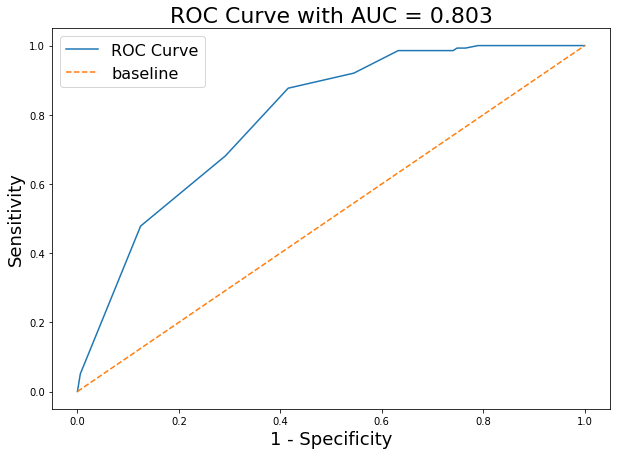

In [36]:
# Creating of figure for AUC ROC graph
plt.figure(figsize = (10,7))

# Create threshold values.
thresholds = np.linspace(0, 1, 200)

# Define function to calculate sensitivity. (True positive rate.)
def TPR(df, true_col, pred_prob_col, threshold):
    true_positive = df[(df[true_col] == 1) & (df[pred_prob_col] >= threshold)].shape[0]
    false_negative = df[(df[true_col] == 1) & (df[pred_prob_col] < threshold)].shape[0]
    return true_positive / (true_positive + false_negative)
    

# Define function to calculate 1 - specificity. (False positive rate.)
def FPR(df, true_col, pred_prob_col, threshold):
    true_negative = df[(df[true_col] == 0) & (df[pred_prob_col] <= threshold)].shape[0]
    false_positive = df[(df[true_col] == 0) & (df[pred_prob_col] > threshold)].shape[0]
    return 1 - (true_negative / (true_negative + false_positive))
    
# Calculate sensitivity & 1-specificity for each threshold between 0 and 1.
tpr_values = [TPR(pred_df, 'true_values', 'pred_probs', prob) for prob in thresholds]
fpr_values = [FPR(pred_df, 'true_values', 'pred_probs', prob) for prob in thresholds]

# Plot ROC curve.
plt.plot(fpr_values, # False Positive Rate on X-axis
         tpr_values, # True Positive Rate on Y-axis
         label='ROC Curve')

# Plot baseline. (Perfect overlap between the two populations.)
plt.plot(np.linspace(0, 1, 200),
         np.linspace(0, 1, 200),
         label='baseline',
         linestyle='--')

# Label axes.
plt.title(f'ROC Curve with AUC = {round(roc_auc_score(pred_df["true_values"], pred_df["pred_probs"]),3)}', fontsize=22)
plt.ylabel('Sensitivity', fontsize=18)
plt.xlabel('1 - Specificity', fontsize=18)

# Create legend.
plt.legend(fontsize=16);

With an AUC score of 0.80, it suggests the 'west nile virus' and 'no west nile virus' populations are well separated, and the model is nearly as good as it can get.

### 4. Submission to Kaggle

In [37]:
def submission_df(pred):
    df = pd.DataFrame(sample['Id'])
    df['WnvPresent'] = pred
    df.set_index(['Id'], inplace = True)
    df.to_csv('answer.csv')
    return df

In [38]:
submission_df(pred_proba_t)

,WnvPresent
Id,
1,0.391792
2,0.391167
3,0.385441
4,0.309967
5,0.309937
...,...
116289,0.394813
116290,0.394780
116291,0.483347


### Kaggle Results:

__Public Score: 0.747__
<br>__Private Score: 0.737__

## 5. Conclusion

Our group chose to utilize an AdaBoost model, with number of estimators = 100 and learning rate of 0.73, which gave a result of ROC score of 0.75 on Kaggle. Our group chose it based on the f-1 score, which suggests a stronger balance between false negative and false positives. An AUC ROC score of 0.80 suggests that the model has classified the two categories relatively well.

### Further improvements

The model can be further stress-tested by:
- Limiting the observations in the train and test dataset to the 3 species of Culex mosquitoes which carry the virus, to improve the modelling accuracy of the models.
- Including the number of mosquitoes as a predicted variable, which would then be used to predict the presence of the virus - this would make sense since the number of mosquitoes might be correlated with the number of positive virus cases
- Increasing the parameters in the gridsearch with the objective of achieving a model with the highest f-1 score